In [90]:
import torch
import matplotlib.pyplot as plt
from torch import distributions
import seaborn as sns
import numpy as np
import torch
import torch.nn as nn
from tqdm.auto import tqdm
import matplotlib as mpl
mpl.rcParams['font.size'] = 14

torch.manual_seed(42)
np.random.seed(42)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

from network import ClassifierNN,load_model_info
from density_utils import draw_density_ratio, refine_sample, refine_sample2, draw_density_ratio2, draw_density_ratio_GP, refine_sample_GP, refine_sample2_GP

from utils import load_item, show_grasp, count_real_positives
from dataset import ToyGraspDataset

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# GP Classifier Sim+ vs Real+

In [91]:
import torch
import matplotlib.pyplot as plt
from torch import distributions
import seaborn as sns
import numpy as np
import torch
import torch.nn as nn
from tqdm.auto import tqdm
import matplotlib as mpl
mpl.rcParams['font.size'] = 14

torch.manual_seed(42)
np.random.seed(42)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

from network import ClassifierNN, train_network, save_model_info, load_model_info

from density_utils import draw_density_ratio, refine_sample, refine_sample2, draw_density_ratio2, refine_sample_GP, draw_density_ratio_GP

from utils import load_item, show_grasp
from dataset import ToyGraspDataset

from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim

torch.manual_seed(42)


sim2real!!!


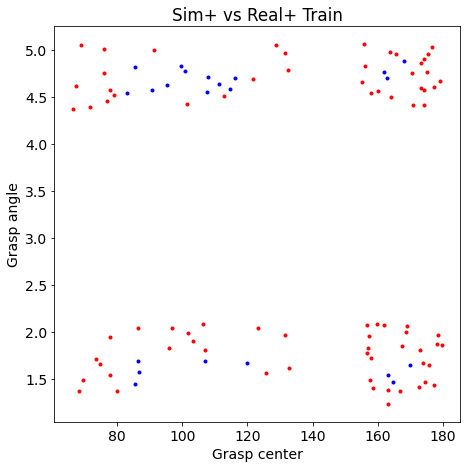

In [92]:
# USING 2D FORK DATA ===============================

n = 10

# train classifier
train_dataset = ToyGraspDataset(root='data', name='sim2real_train', size=100, is_pos_label=True, device=device)
# train_dataloader = DataLoader(train_dataset, batch_size=10, shuffle=True)

test_dataset = ToyGraspDataset(root='data', name='sim2real_test', size=n, is_pos_label=True, device=device)
# test_dataloader = DataLoader(test_dataset, batch_size=512, shuffle=False)



# dataset = ToyGraspDataset(root='data', size=50)
train_x = torch.Tensor(train_dataset.data[:,:2])
train_y = torch.Tensor(train_dataset.data[:,2]).long().to(device)

x_t = train_x.clone().to(device)
# Normalize inputs
x_t[:,0] /= 244
x_t[:,1] /= (3.14*2)


fig = plt.figure(figsize=(16,16))
ax1 = fig.add_subplot(221)

# show the data
data = train_dataset.data
pos_masks = data[:,2] == 1
neg_masks = ~pos_masks

ax1.scatter(data[pos_masks][:,0], data[pos_masks][:,1], marker='.', alpha=1.0, color='b')
ax1.scatter(data[neg_masks][:,0], data[neg_masks][:,1], marker='.', alpha=1.0, color='r')
ax1.set_title('Sim+ vs Real+ Train')
ax1.set_xlabel('Grasp center')
ax1.set_ylabel('Grasp angle')

plt.show()

In [93]:
import math
import torch
import numpy as np
import gpytorch
from matplotlib import pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

from gpytorch.models import ExactGP
from gpytorch.likelihoods import DirichletClassificationLikelihood
from gpytorch.means import ConstantMean
from gpytorch.kernels import ScaleKernel, RBFKernel

from network import ExactGPModel





# likelihood = gpytorch.likelihoods.GaussianLikelihood().to(device)
likelihood = gpytorch.likelihoods.GaussianLikelihood().to(device)
model = ExactGPModel(x_t, train_y, likelihood).to(device)




# this is for running the notebook in our testing framework
import os
smoke_test = ('CI' in os.environ)
training_iter = 2 if smoke_test else 4000


# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()

    # Output from model
    output = likelihood(model(x_t))

    # Calc loss and backprop gradients
    loss = -mll(output, train_y).sum()
    loss.backward()
    optimizer.step()
        
    if i % 400 == 0:

        print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
            i + 1, training_iter, loss.item(),
            model.covar_module.base_kernel.lengthscale.item(),
            model.likelihood.noise.item()
        ))        
#         print('Iter %d/%d - Loss: %.3f - Acc: %.3f' % (i + 1, training_iter, loss.item(), train_accuracy))
#         print('Iter %d/%d - Loss: %.3f' % (i + 1, training_iter, loss.item()))


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Iter 1/4000 - Loss: 1.177   lengthscale: 0.744   noise: 0.644
Iter 401/4000 - Loss: 0.360   lengthscale: 0.021   noise: 0.014
Iter 801/4000 - Loss: 0.346   lengthscale: 0.021   noise: 0.015
Iter 1201/4000 - Loss: 0.337   lengthscale: 0.019   noise: 0.013
Iter 1601/4000 - Loss: 0.340   lengthscale: 0.021   noise: 0.014
Iter 2001/4000 - Loss: 0.344   lengthscale: 0.021   noise: 0.013
Iter 2401/4000 - Loss: 0.377   lengthscale: 0.023   noise: 0.018
Iter 2801/4000 - Loss: 0.358   lengthscale: 0.021   noise: 0.017
Iter 3201/4000 - Loss: 0.370   lengthscale: 0.019   noise: 0.011
Iter 3601/4000 - Loss: 0.391   lengthscale: 0.023   noise: 0.016


In [94]:
steps_refinement = 100


# from the GP classifier
# f2
# Nq = info2['pos_samples_size'], Np = info2['neg_samples_size']

Nq = int(train_y.sum())
Np = int(train_y.size()[0] - train_y.sum())

# print(my_sample)
# my_sample = torch.FloatTensor([[25, 0.3],
my_sample = torch.FloatTensor([[60, 1.5],
                               [210, 3]])#[160, 3]
# my_sample = torch.FloatTensor([[210, 3]])

my_sample[:,0] /= 224
my_sample[:,1] /= (2*3.14)

# my_sample = my_sample.repeat(1,200)

model.to(device)
model.eval()
likelihood.to(device)
likelihood.eval()

all_x1, all_v1 = refine_sample_GP(my_sample.to(device), model, likelihood, steps=steps_refinement,
# all_x1, all_v1 = refine_sample_GP(my_sample.to(device), model, steps=steps_refinement,
#                                eta=0.0001, noise_factor=0.0000,
                               eta=0.1, noise_factor=0.000,
#                                eta=0.5, noise_factor=0.000,
                              Nq = Nq, Np = Np)

22 78


  0%|          | 0/100 [00:00<?, ?it/s]

In [95]:
# # train_x
# # all_x1
# # my_sample.size()
# # my_sample
# model.eval()
# # print(x_t)
# out = model(x_t.to(device)).loc
# print(max(out).item(), min(out).item())

  0%|          | 0/10 [00:00<?, ?it/s]

0.43119562 0.7787277


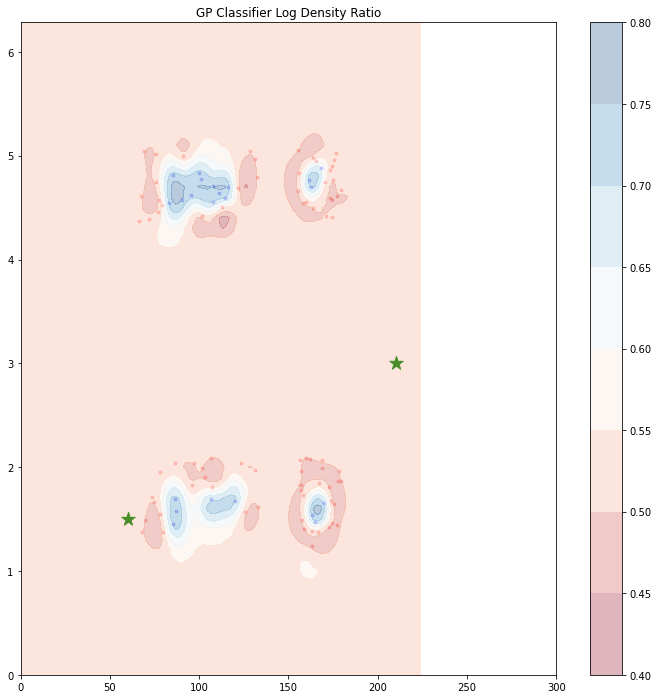

In [96]:
import torch
torch.cuda.empty_cache()
fig, ax = plt.subplots(nrows=1, figsize=(12,12))
ax.scatter(train_x[pos_masks][:,0], train_x[pos_masks][:,1], marker='.', alpha=0.2, color='b')
ax.scatter(train_x[neg_masks][:,0], train_x[neg_masks][:,1], marker='.', alpha=0.2, color='r')

plt.scatter(my_sample[:, 0]*224, my_sample[:,1]*(2*3.14), marker='*', color='g', s=200)
# plt.scatter(my_sample[:, 0], my_sample[:,1], marker='*', color='g', s=200)

for i in range(1, steps_refinement, 1):
    plt.scatter(all_x1[i][:, 0]*224, all_x1[i][:,1]*(2*3.14), marker='d', color='g', s=4)
#     plt.scatter(all_x1[i][:, 0], all_x1[i][:,1], marker='d', color='g', s=4)


Z, CS = draw_density_ratio_GP(ax=ax,
                   model=model,
                   likelihood=likelihood,
                   p_type='p_y_given_x',
#                    p_type='log_density_ratio',
                   device=device,
                   x_lim=[0, 224],
                   y_lim=[0, 2*np.pi],
                   cmap='RdBu',
                   step_size=0.1,
                   Np=Np, Nq=Nq)
fig.colorbar(CS, ax=ax)



ax.set_title(f'GP Classifier Log Density Ratio')
ax.set_xlim([0, 300])
ax.set_ylim([0, 2*np.pi])

plt.show()

In [111]:
my_sample = torch.FloatTensor([[60, 1.5],
                               [80, 1.5],
                               [0.0, 0.0],
                               [160, 1.5]]).to(device)

my_sample[:,0] /= 224
my_sample[:,1] /= (2*3.14)


model.to(device)
model.eval()
pred = model(my_sample).mean
print(pred)
# print(min(pred).item(), max(pred).item())

tensor([0.1168, 1.0030, 0.1815, 0.2199], device='cuda:0',
       grad_fn=<ViewBackward0>)


NameError: name 'test_x' is not defined

In [45]:
import tqdm
import math
import torch
import gpytorch
from matplotlib import pyplot as plt

# Make plots inline
%matplotlib inline

import torch
import numpy as np
from density_utils import draw_density_ratio, refine_sample, refine_sample2, draw_density_ratio2, draw_density_ratio_GP, refine_sample_GP, refine_sample2_GP
torch.cuda.empty_cache()

import os

In [46]:
# import urllib.request
# import os
# from scipy.io import loadmat
# from math import floor


# # this is for running the notebook in our testing framework
# smoke_test = ('CI' in os.environ)


# if not smoke_test and not os.path.isfile('../elevators.mat'):
#     print('Downloading \'elevators\' UCI dataset...')
#     urllib.request.urlretrieve('https://drive.google.com/uc?export=download&id=1jhWL3YUHvXIaftia4qeAyDwVxo6j1alk', '../elevators.mat')

# X, y = torch.randn(1000, 3), torch.randn(1000)

# # if smoke_test:  # this is for running the notebook in our testing framework
# #     X, y = torch.randn(1000, 3), torch.randn(1000)
# # else:
# #     data = torch.Tensor(loadmat('../elevators.mat')['data'])
# #     X = data[:, :-1]
# #     X = X - X.min(0)[0]
# #     X = 2 * (X / X.max(0)[0]) - 1
# #     y = data[:, -1]


# train_n = int(floor(0.8 * len(X)))
# train_x = X[:train_n, :].contiguous()
# train_y = y[:train_n].contiguous()

# test_x = X[train_n:, :].contiguous()
# test_y = y[train_n:].contiguous()

# if torch.cuda.is_available():
#     train_x, train_y, test_x, test_y = train_x.cuda(), train_y.cuda(), test_x.cuda(), test_y.cuda()

In [47]:

# from torch.utils.data import TensorDataset, DataLoader
# train_dataset = TensorDataset(train_x, train_y)
# train_loader = DataLoader(train_dataset, batch_size=1024, shuffle=True)

# test_dataset = TensorDataset(test_x, test_y)
# test_loader = DataLoader(test_dataset, batch_size=1024, shuffle=False)

In [82]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
n = 50
from dataset import ToyGraspDataset
from torch.utils.data import TensorDataset, DataLoader

# train classifier
train_dataset = ToyGraspDataset(root='data', name='sim2real_train', size=10000, is_pos_label=True, device=device)
test_dataset = ToyGraspDataset(root='data', name='sim2real_test', size=n, is_pos_label=True, device=device)

train_data = torch.Tensor(train_dataset.data).to(device)
test_data = torch.Tensor(test_dataset.data).to(device)


train_x = train_data[:,:2]
train_y = train_data[:,2]
test_x = test_data[:,:2]
test_y = test_data[:,2]
pos_mask = train_y == 1
neg_mask = ~pos_mask


train_dataset = TensorDataset(train_x, train_y)
train_loader = DataLoader(train_dataset, batch_size=1024, shuffle=True)

test_dataset = TensorDataset(test_x, test_y)
test_loader = DataLoader(test_dataset, batch_size=1024, shuffle=False)


sim2real!!!


In [83]:
print(train_x[0])
print(train_y[0])
print(test_x[0])
print(test_y[0])

tensor([108.6242,   4.7700], device='cuda:0')
tensor(1., device='cuda:0')
tensor([65.0000,  1.2217], device='cuda:0')
tensor(0., device='cuda:0')


In [88]:
from gpytorch.models import ApproximateGP
from gpytorch.variational import CholeskyVariationalDistribution
from gpytorch.variational import VariationalStrategy

class ApproximateGPModel(ApproximateGP):
    def __init__(self, inducing_points):
        variational_distribution = CholeskyVariationalDistribution(inducing_points.size(0))
        variational_strategy = VariationalStrategy(self, inducing_points, variational_distribution, learn_inducing_locations=True)
        super(ApproximateGPModel, self).__init__(variational_strategy)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

inducing_points = train_x[:5000, :]
inducing_points[:,0] /= 244
inducing_points[:,1] /= 2*(3.14)
model = ApproximateGPModel(inducing_points=inducing_points)
likelihood = gpytorch.likelihoods.GaussianLikelihood()

if torch.cuda.is_available():
    model = model.cuda()
    likelihood = likelihood.cuda()

In [89]:
import os
smoke_test = ('CI' in os.environ)
num_epochs = 1 if smoke_test else 5


model.train()
likelihood.train()

optimizer = torch.optim.Adam([
    {'params': model.parameters()},
    {'params': likelihood.parameters()},
], lr=0.1)

# Our loss object. We're using the VariationalELBO
# mll = gpytorch.mlls.VariationalELBO(likelihood, model, num_data=train_y.size(0))
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)


epochs_iter = tqdm.notebook.tqdm(range(num_epochs), desc="Epoch")
with gpytorch.settings.cholesky_jitter(1e-1):
    for i in epochs_iter:
        # Within each iteration, we will go over each minibatch of data
        minibatch_iter = tqdm.notebook.tqdm(train_loader, desc="Minibatch", leave=False)
        for x_batch, y_batch in minibatch_iter:
            x_batch[:,0] /= 244
            x_batch[:,1] /= (3.14*2)
            optimizer.zero_grad()
            output = model(x_batch)
            loss = -mll(output, y_batch)
            minibatch_iter.set_postfix(loss=loss.item())
            loss.backward()
            optimizer.step()
#         if i*10 == 0:
#             print(loss.item())

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
model.eval()
likelihood.eval()
means = torch.tensor([0.])
with torch.no_grad():
    for x_batch, y_batch in test_loader:
        x_batch[:,0] /= 244
        x_batch[:,1] /= (3.14*2)        
        preds = model(x_batch)
        means = torch.cat([means, preds.mean.cpu()])
means = means[1:]
print('Test MAE: {}'.format(torch.mean(torch.abs(means - test_y.cpu()))))


In [ ]:
steps_refinement = 100


# from the GP classifier
# f2
# Nq = info2['pos_samples_size'], Np = info2['neg_samples_size']

Nq = int(train_y.sum())
Np = int(train_y.size()[0] - train_y.sum())

# print(my_sample)
# my_sample = torch.FloatTensor([[25, 0.3],
my_sample = torch.FloatTensor([[60, 1.5],
                               [210, 3]])#[160, 3]
# my_sample = torch.FloatTensor([[210, 3]])

my_sample[:,0] /= 224
my_sample[:,1] /= (2*3.14)

# my_sample = my_sample.repeat(1,200)

model.to(device)
model.eval()
likelihood.to(device)
likelihood.eval()

all_x1, all_v1 = refine_sample_GP(my_sample.to(device), model, likelihood, steps=steps_refinement,
# all_x1, all_v1 = refine_sample_GP(my_sample.to(device), model, steps=steps_refinement,
#                                eta=0.0001, noise_factor=0.0000,
                               eta=0.1, noise_factor=0.000,
#                                eta=0.5, noise_factor=0.000,
                              Nq = Nq, Np = Np)

In [ ]:



Nq = int(train_y.sum())
Np = int(train_y.size()[0] - train_y.sum())
print(Np,Nq)
train_x= train_x.cpu()
fig, ax = plt.subplots(nrows=1, figsize=(12,12))
ax.scatter(train_x[pos_mask][:,0]*244, train_x[pos_mask][:,1]*(2*3.14), marker='.', alpha=0.2, color='b')
ax.scatter(train_x[neg_mask][:,0]*244, train_x[neg_mask][:,1]*(2*3.14), marker='.', alpha=0.2, color='r')

plt.scatter(my_sample[:, 0]*224, my_sample[:,1]*(2*3.14), marker='*', color='g', s=200)
# plt.scatter(my_sample[:, 0], my_sample[:,1], marker='*', color='g', s=200)

for i in range(1, steps_refinement, 1):
    plt.scatter(all_x1[i][:, 0]*224, all_x1[i][:,1]*(2*3.14), marker='d', color='g', s=4)
#     plt.scatter(all_x1[i][:, 0], all_x1[i][:,1], marker='d', color='g', s=4)



Z, CS = draw_density_ratio_GP(ax=ax,
                   model=model,
                   likelihood=likelihood,
                   p_type='p_y_given_x',
#                    p_type='log_density_ratio',
                   device=device,
                   x_lim=[0, 224],
                   y_lim=[0, 2*np.pi],
                   cmap='RdBu',
                   step_size=0.1,
                   Np=Np, Nq=Nq)
fig.colorbar(CS, ax=ax)



ax.set_title(f'GP Classifier Log Density Ratio')
# ax.set_xlim([0, 300])
# ax.set_ylim([0, 2*np.pi])

plt.show()